# Se connecter au drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/PLDAC/darknet
%ls

Mounted at /content/gdrive
/content/gdrive/My Drive/PLDAC/darknet
3rdparty/                evaluation.py          resultats/
backup/                  image_yolov3.sh        results/
build/                   image_yolov4.sh        scripts/
build.ps1                include/               split_aug.py
cfg/                     json_mjpeg_streams.sh  src/
chart.png                libdarknet.so          uselib
chart_yolov4-custom.png  LICENSE                vcpkg.json
cmake/                   Makefile               vcpkg.json.opencv23
CMakeLists.txt           net_cam_v3.sh          video_yolov3.sh
darknet                  net_cam_v4.sh          video_yolov4.sh
DarknetConfig.cmake.in   obj/                   weights_cfg/
darknet_images.py        prediction/            yolov4.conv.137
darknet.py               prediction_stats/      yolov4.weights
darknet_video.py         process.py
data/                    README.md


In [2]:
!chmod +x ./darknet
%ls

3rdparty/                evaluation.py          resultats/
backup/                  image_yolov3.sh        results/
build/                   image_yolov4.sh        scripts/
build.ps1                include/               split_aug.py
cfg/                     json_mjpeg_streams.sh  src/
chart.png                libdarknet.so          uselib
chart_yolov4-custom.png  LICENSE                vcpkg.json
cmake/                   Makefile               vcpkg.json.opencv23
CMakeLists.txt           net_cam_v3.sh          video_yolov3.sh
darknet*                 net_cam_v4.sh          video_yolov4.sh
DarknetConfig.cmake.in   obj/                   weights_cfg/
darknet_images.py        prediction/            yolov4.conv.137
darknet.py               prediction_stats/      yolov4.weights
darknet_video.py         process.py
data/                    README.md


# Fonctions d'affichage sur le drive

In [3]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

In [4]:
%cd ./cfg
!sed -i 's/batch=32/batch=1/' yolov4-custom.cfg
!sed -i 's/subdivisions=32/subdivisions=1/' yolov4-custom.cfg
%cd ..

/content/gdrive/My Drive/PLDAC/darknet/cfg
/content/gdrive/My Drive/PLDAC/darknet


# Test de prédiction sur l'image 0041408

In [5]:
!./darknet detector test data/piford.data cfg/yolov4-custom.cfg backup/yolov4-custom_best.weights data/piford/0041408.bmp -thresh 0.3 -dont_show -map -ext_output -out 0041408.txt

 CUDA-version: 11080 (12000), cuDNN: 8.7.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv   

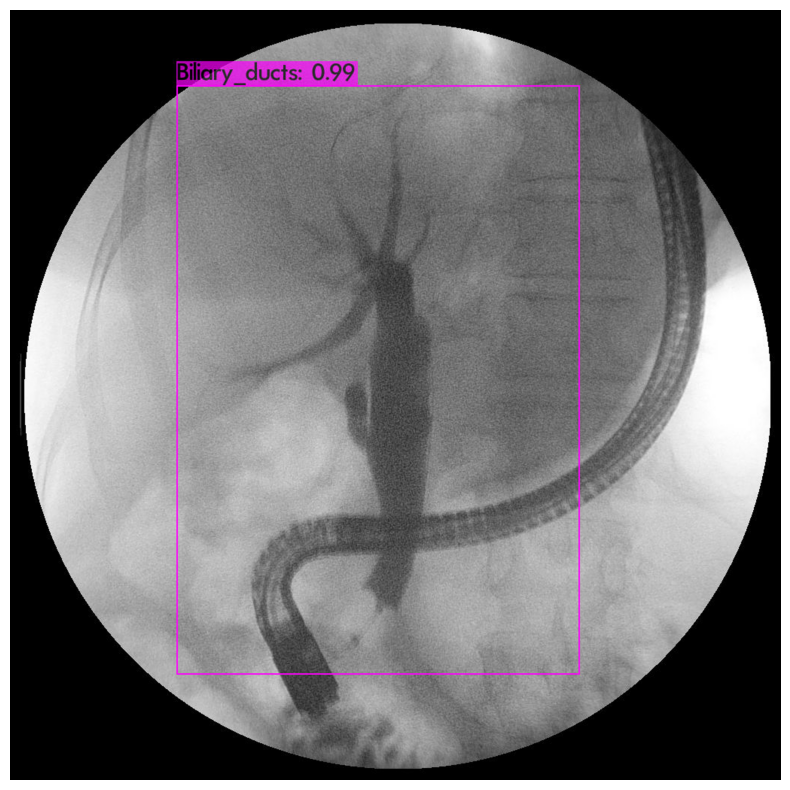

In [6]:
imShow('predictions.jpg')

# Prédictions avec evaluation.py



In [7]:
import evaluation 

## Cas d'une prédiction pour un modèle dont les poids sont dans backup

Cette première utilisaiton de evaluation.py correspond par exemple à un cas où l'on vient d'entraîner un modèle et que l'on souhaite désormais effectuer toutes les prédictions sur les images de test ainsi que d'évaluer notre modèle.   
On obtient alors les résultats des prédictions dans le dossier 'prediction' et toutes les statistiques d'évaluation dans le dossier 'prediction_stats'. Ces deux dossiers se trouvent dans le dossier darknet.    
Dans le dossier 'prediction' on trouve pour chaque image de test : 
  - Un fichier .txt avec le résultat de la prédiction.
  - Une image au format .jpg avec la bbox réelle et celle prédite ainsi que le score de confiance et le score IoU.     
  
Dans le dossier 'prediction_stats' on trouve :
  - avg_iou.txt : contenant la moyenne des scores IoU obtenus lors des prédictions.
  - best_score_map.txt : contenant le meilleur score MAP obtenu (selon le threshold utilisé pour effectuer la prédiction).
  - best_threshold.txt : contenant le threshold permettant de maximiser la MAP. 
  - chart.png : correspondant à la courbe d'apprentissage qui avait été obtenue lors du dernier train effectué.
  - confidences.txt : contenant les scores de confiance pour chaque image.
  - confusion_matrix.jpg : la matrice de confusion obtenue sur nos données test (vrai positif, vrai négatig, faux positif et faux négatif).
  - coord_pred.txt : contenant les coordonnées prédites pour chaque image. 
  - coord_true.txt : contenant les coordonées réelles pour chaque image. 
  - MAP_vs_threshold.jpg : courbe présentant l'évolution de la MAP en fonction du threshold. 
  - Precisions_curve.jpg : courbe présentant l'évolution de la précision en fonction du threshold. 
  - Precisions_recall_curve : courbe présentant la précision en fonction du rappel. 
  - prediction_times.txt : contenant les temps de chaque prédiction ainsi que le temps moyen de prédiction (en ms et FPS).
  - Recalls_curve.jpg : courbe présentant l'évolution du recall en foncion du threshold. 
  - scores_ciou.txt : contenant les score CIoU obtenus pour chaque image. 
  - test.txt : fichier listant les images ayant été utilisées pour le test.
  - train.txt : fichier listant les images ayant été utilisées pour l'entraînement.
  - yolov4-custom_best.weights : meilleur poids ayant été obtenu lors de l'appprentissage. 



In [8]:
evaluation.run('data/test.txt', '', '', '', True)


Output hidden; open in https://colab.research.google.com to view.

## Cas pour évaluer tous les modèles 

Ce second cas de figure permet de

In [9]:
evaluation.run_all('data/test.txt')

Output hidden; open in https://colab.research.google.com to view.